## 1. Importar Dados

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/WittmannF/awari-calculadora-imoveis-may-20/master/1-web-scraping/dados_calculadora_imoveis_aula.csv')

In [2]:
df.head()

,zona,quartos,area,preco
0,norte,1.0,70.0,600
1,norte,2.0,70.0,850
2,norte,1.0,40.0,850
3,norte,1.0,50.0,950
4,norte,1.0,160.0,790


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quartos,996.0,2.522088,1.444628,1.0,2.00,2.0,3.0,13.0
area,1120.0,173.453571,155.656067,1.0,62.75,120.0,250.0,1423.0
preco,1152.0,7076.252604,52003.899822,449.0,1300.00,2500.0,6500.0,1700000.0


## 2. Análise Exploratória e Preprocessamento

In [4]:
from sklearn.model_selection import train_test_split

treino, teste = train_test_split(df, 
                                 stratify=df['zona'], 
                                 test_size=0.25,
                                 random_state=0
                                 )

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


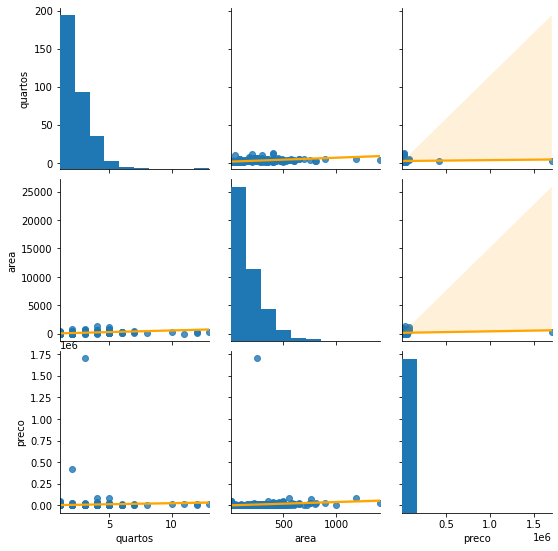

In [5]:
import seaborn as sns
sns.pairplot(treino, kind='reg', plot_kws={'line_kws':{'color':'orange'}})

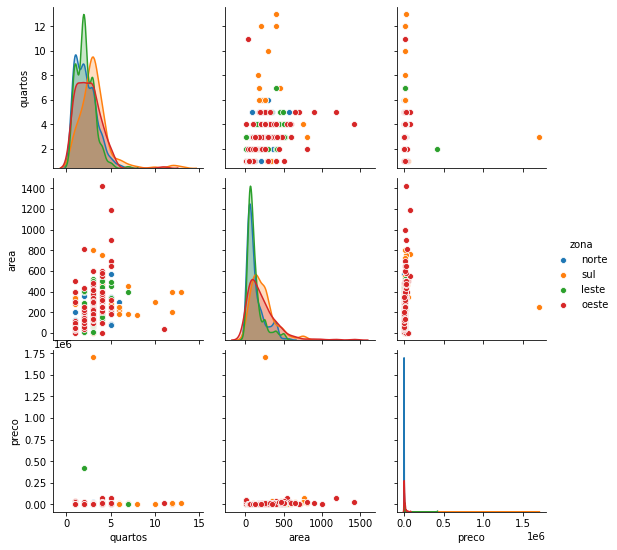

In [6]:
sns.pairplot(treino, hue='zona')

In [7]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 18 to 620
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   zona     864 non-null    object 
 1   quartos  751 non-null    float64
 2   area     843 non-null    float64
 3   preco    864 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 73.8+ KB


### 2.1 Tratamento dos dados numéricos




In [8]:
num_cols = ['quartos', 'area', 'preco']
treino_num = treino[num_cols]

In [9]:
# Preencher NaN
treino_medianas = treino_num.median()
treino_num = treino_num.fillna(treino_medianas)
treino_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 18 to 620
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   quartos  864 non-null    float64
 1   area     864 non-null    float64
 2   preco    864 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 27.0 KB


In [10]:
# Aplicar log nos dados
import numpy as np
treino_num=treino_num.apply(np.log1p)

In [11]:
treino[num_cols] = treino_num

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


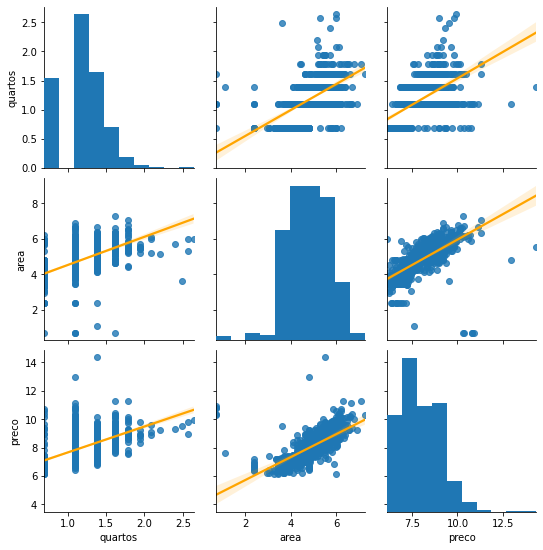

In [12]:
sns.pairplot(treino, kind='reg', plot_kws={'line_kws':{'color':'orange'}})

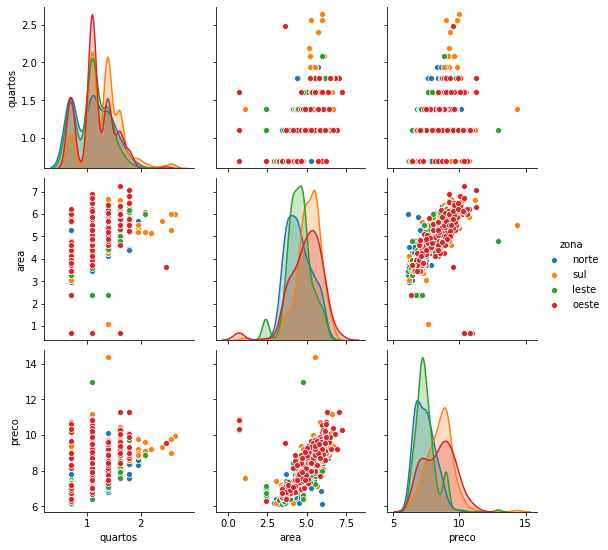

In [13]:
sns.pairplot(treino, hue='zona')

In [14]:
# Análise de outliers

REMOVER_OUTLIERS = False

quartis = treino_num.quantile([0.25,0.5,0.75])

Q1 = quartis.loc[0.25]
Q3 = quartis.loc[0.75]
IQR = Q3-Q1

k = 1.5 
limite_inferior = Q1-k*IQR
limite_superior = Q1+k*IQR

treino_num_sem_outlier = treino_num[treino_num>=limite_inferior].dropna()
treino_num_sem_outlier = treino_num_sem_outlier[treino_num_sem_outlier<=limite_superior].dropna()

if REMOVER_OUTLIERS:
  treino = treino.loc[treino_num_sem_outlier.index]

treino_num_sem_outlier

,quartos,area,preco
18,1.386294,5.484797,7.496097
461,1.386294,5.303305,7.863651
249,0.693147,3.433987,6.552508
632,1.098612,4.510860,7.003974
439,1.098612,6.111467,8.612685
...,...,...,...
305,0.693147,3.433987,7.090910
450,1.098612,5.043425,8.366603
699,1.098612,4.110874,7.131699
792,0.693147,4.595120,7.313887


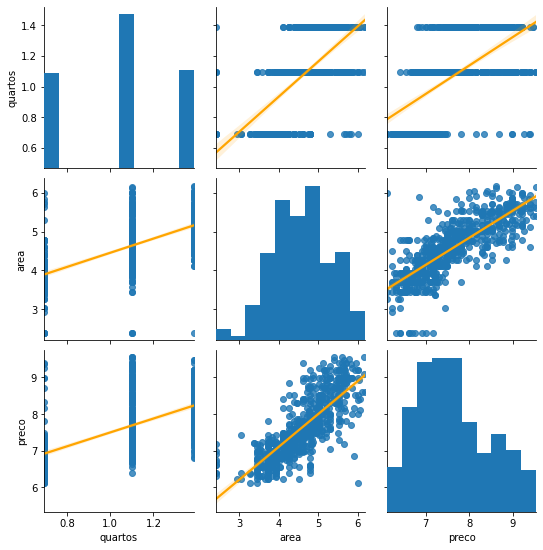

In [15]:
sns.pairplot(treino_num_sem_outlier, kind='reg', plot_kws={'line_kws':{'color':'orange'}})

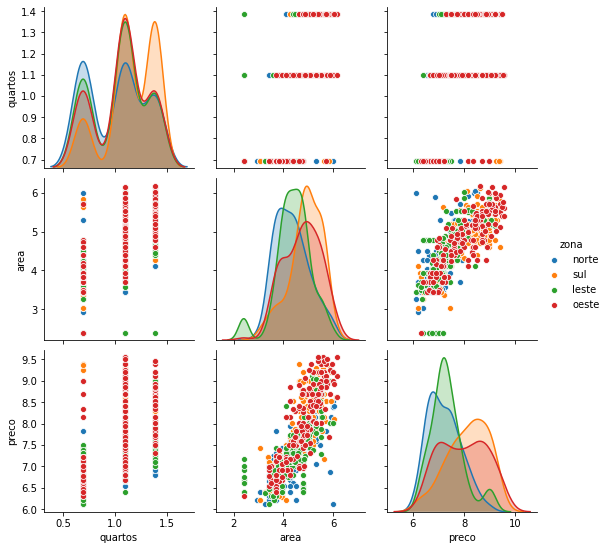

In [16]:
sns.pairplot(treino.loc[treino_num_sem_outlier.index], hue='zona')

### 2.2 Colunas categóricas

In [17]:
cat_cols = ['zona']
treino_cat = treino[cat_cols]

In [18]:
# Vantagem de get_dummies: Lida automaticamente com NaNs (todos zeros)
treino_cat = pd.get_dummies(treino_cat)

In [19]:
treino = pd.concat([treino_cat, treino.drop(cat_cols, axis=1)], axis=1)

In [20]:
treino.head()

,zona_leste,zona_norte,zona_oeste,zona_sul,quartos,area,preco
18,0,1,0,0,1.386294,5.484797,7.496097
461,0,0,0,1,1.386294,5.303305,7.863651
249,0,1,0,0,0.693147,3.433987,6.552508
632,1,0,0,0,1.098612,4.510860,7.003974
458,0,0,0,1,1.098612,6.111467,9.615872


### 2.3 Repetir preprocessamentos para o conjunto de testes

In [21]:
# Preencher NaN 
# Importante: NUNCA usar informações do conjunto de testes, por isso estamos usando as medianas do conjunto de treino
teste = teste.fillna(treino_medianas)
teste.head()

,zona,quartos,area,preco
442,sul,2.0,397.0,12000
304,sul,2.0,140.0,2200
1078,oeste,4.0,340.0,9500
497,sul,12.0,300.0,7500
741,leste,2.0,50.0,860


In [22]:
# Aplicar log nos valores numericos
teste[num_cols] = teste[num_cols].apply(np.log1p)
teste.head()

,zona,quartos,area,preco
442,sul,1.098612,5.986452,9.392745
304,sul,1.098612,4.948760,7.696667
1078,oeste,1.609438,5.831882,9.159152
497,sul,2.564949,5.707110,8.922792
741,leste,1.098612,3.931826,6.758095


In [23]:
# One-Hot Encoding
teste_onehot = pd.get_dummies(teste[cat_cols])
teste=pd.concat([teste_onehot, teste[num_cols]], axis=1)
teste.head()

,zona_leste,zona_norte,zona_oeste,zona_sul,quartos,area,preco
442,0,0,0,1,1.098612,5.986452,9.392745
304,0,0,0,1,1.098612,4.948760,7.696667
1078,0,0,1,0,1.609438,5.831882,9.159152
497,0,0,0,1,2.564949,5.707110,8.922792
741,1,0,0,0,1.098612,3.931826,6.758095


### 2.4 Exportar treino e teste preprocessado

In [24]:
treino.to_csv('treino_preprocessado.csv', index=False)

In [25]:
teste.to_csv('teste_preprocessado.csv', index=False)